# Scenario Simulation & Decision Latency Risk  
## Wine Quality under Alcohol-Driven Regimes

This notebook develops a scenario simulation framework to assess latent quality risk
in wine production under delayed market feedback conditions.

Using a stable baseline wine profile, we simulate chemical shocks and assess how
quality is expected to respond before market signals become observable.


## Why scenario simulation?

Wine producers operate under delayed feedback cycles: the impact of production decisions
on perceived quality is often only observable years later, when corrective action is no
longer possible.

Rather than predicting quality for past observations, this notebook focuses on
*what-if scenarios* to proactively assess risk under plausible chemical deviations.


## Baseline wine definition

Based on previous exploratory and modeling analysis, the alcohol range between 10% and 12%
represents the most stable and representative regime in the dataset:

- Balanced chemical profiles
- Intermediate quality scores
- Highest structural sensitivity to chemical variation

For this reason, the baseline state for all simulations is defined as the *average wine*
within the 10–12% alcohol segment.


In [4]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path

# Load project configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
WINE_QUALITY_FILE = config["files"]["wine_quality"]

wine_quality = pd.read_csv(RAW_PATH / WINE_QUALITY_FILE)

In [8]:
wine_quality["alcohol_segment_3"] = pd.cut(
    wine_quality["alcohol"],
    bins=[0, 10, 12, float("inf")],
    labels=["<10%", "10–12%", ">12%"],
    right=False
)

if "Id" in wine_quality.columns:
    wine_quality = wine_quality.drop(columns=["Id"])

In [9]:
baseline_df = wine_quality[wine_quality["alcohol_segment_3"] == "10–12%"]

baseline_profile = baseline_df.mean(numeric_only=True)
baseline_profile


fixed acidity            8.387127
volatile acidity         0.519496
citric acid              0.276642
residual sugar           2.497388
chlorides                0.080735
free sulfur dioxide     15.165112
total sulfur dioxide    38.199627
density                  0.996559
pH                       3.324608
sulphates                0.665746
alcohol                 10.814241
quality                  5.824627
dtype: float64

## Load the trained quality model (alcohol-aware)

Simulations require a trained model to translate chemical changes into expected quality changes.
We use the alcohol-aware global model (Ridge + standardization), consistent with the project choice:
a global model plus segment logic.


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1) Prepare modeling dataset (drop Id, keep alcohol_segment_3 separately)
wine_sim = wine_quality.copy()

# Drop irrelevant identifier
wine_sim = wine_sim.drop(columns=["Id"], errors="ignore")

# Create X/y
y = wine_sim["quality"]
X = wine_sim.drop(columns=["quality"], errors="ignore")

# Add alcohol segment as a categorical feature
X = X.copy()
X["alcohol_segment"] = wine_sim["alcohol_segment_3"]

# One-hot encode
X = pd.get_dummies(X, drop_first=True)

# 2) Train pipeline
quality_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

quality_model.fit(X, y)

# Optional quick sanity check (CV)
rmse_cv = -cross_val_score(
    quality_model, X, y,
    scoring="neg_root_mean_squared_error",
    cv=5
).mean()

r2_cv = cross_val_score(
    quality_model, X, y,
    scoring="r2",
    cv=5
).mean()

rmse_cv, r2_cv


(np.float64(0.6537256276130197), np.float64(0.3091840998752754))

## Define simulation features and baseline vector

We simulate deviations around the baseline profile (10–12% alcohol).
Alcohol is kept constant to isolate second-order chemical effects within a stable regime.

We will simulate:
- volatile acidity
- fixed acidity
- pH
- total sulfur dioxide
- free sulfur dioxide
- residual sugar


In [11]:
sim_features = [
    "volatile acidity",
    "fixed acidity",
    "pH",
    "total sulfur dioxide",
    "free sulfur dioxide",
    "residual sugar"
]

# Build a baseline "row" (single observation) starting from baseline_profile
baseline_row = baseline_profile.copy()

# Ensure the alcohol segment is explicitly set
baseline_row["alcohol_segment_3"] = "10–12%"

# Create a single-row DataFrame aligned with original columns
baseline_df_row = pd.DataFrame([baseline_row])

# Build X baseline in the same format as training
X_base = baseline_df_row.drop(columns=["quality"], errors="ignore").copy()
X_base["alcohol_segment"] = baseline_df_row["alcohol_segment_3"]
X_base = X_base.drop(columns=["alcohol_segment_3"], errors="ignore")

# One-hot encode and align columns to training X
X_base = pd.get_dummies(X_base, drop_first=True)
X_base = X_base.reindex(columns=X.columns, fill_value=0)

# Baseline prediction
baseline_pred_quality = quality_model.predict(X_base)[0]
baseline_pred_quality


np.float64(5.735531830082987)

## One-at-a-time sensitivity analysis

Each feature is perturbed independently while all other features remain fixed at baseline values.
We evaluate the expected change in predicted quality and visualize the relationship.

This identifies which parameters are high-leverage risk drivers under delayed feedback.


In [12]:
def simulate_one_feature(
    feature_name: str,
    base_row: pd.Series,
    model,
    X_train_columns,
    deltas: np.ndarray
) -> pd.DataFrame:
    """
    Perturb one feature around baseline and compute predicted quality.
    deltas are expressed as relative changes, e.g. -0.1 means -10%.
    """
    records = []
    for d in deltas:
        row = base_row.copy()
        row[feature_name] = row[feature_name] * (1 + d)

        # Build single-row DF
        df_row = pd.DataFrame([row])

        # Build X in same format as training
        X_row = df_row.drop(columns=["quality"], errors="ignore").copy()
        X_row["alcohol_segment"] = df_row["alcohol_segment_3"]
        X_row = X_row.drop(columns=["alcohol_segment_3"], errors="ignore")

        X_row = pd.get_dummies(X_row, drop_first=True)
        X_row = X_row.reindex(columns=X_train_columns, fill_value=0)

        pred = model.predict(X_row)[0]
        records.append({
            "feature": feature_name,
            "delta_pct": d * 100,
            "feature_value": row[feature_name],
            "pred_quality": pred,
            "delta_quality": pred - baseline_pred_quality
        })
    return pd.DataFrame(records)

deltas = np.array([-0.20, -0.10, -0.05, 0.00, 0.05, 0.10, 0.20])

sensitivity_results = pd.concat(
    [
        simulate_one_feature(f, baseline_row, quality_model, X.columns, deltas)
        for f in sim_features
    ],
    ignore_index=True
)

sensitivity_results.head()


,feature,delta_pct,feature_value,pred_quality,delta_quality
0,volatile acidity,-20.0,0.415597,5.853031,0.117499
1,volatile acidity,-10.0,0.467547,5.794281,0.058750
2,volatile acidity,-5.0,0.493521,5.764907,0.029375
3,volatile acidity,0.0,0.519496,5.735532,0.000000
4,volatile acidity,5.0,0.545471,5.706157,-0.029375


## Sensitivity plots

We visualize the relationship between feature changes and predicted quality.
The dashed horizontal line indicates baseline predicted quality.


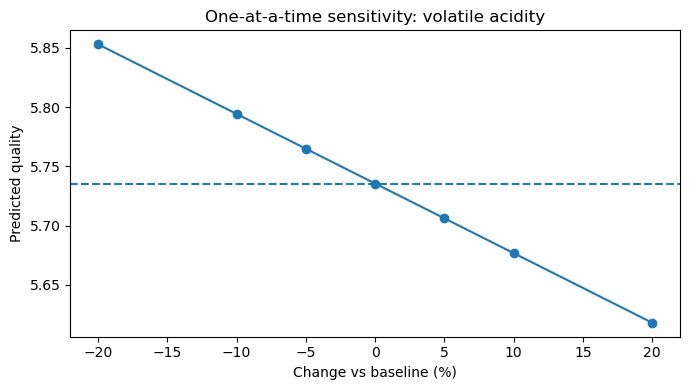

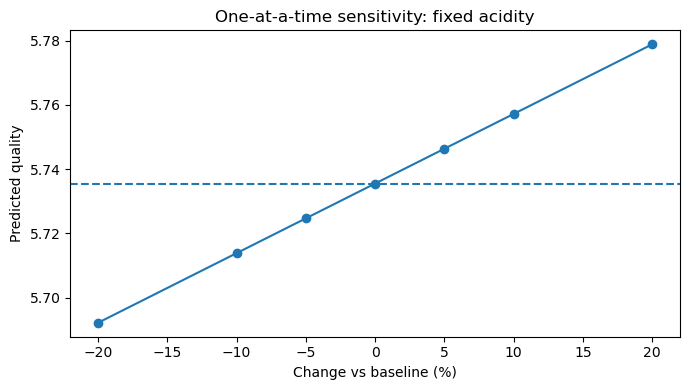

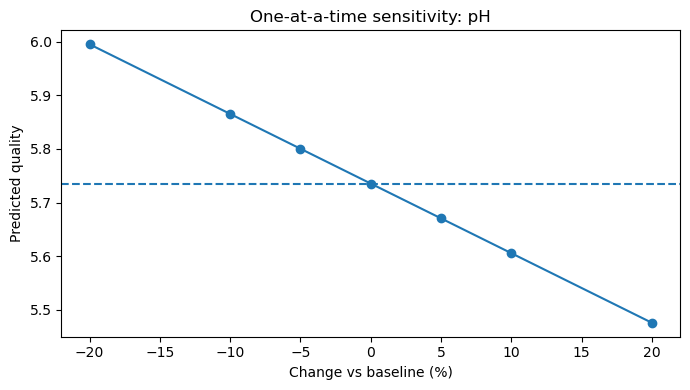

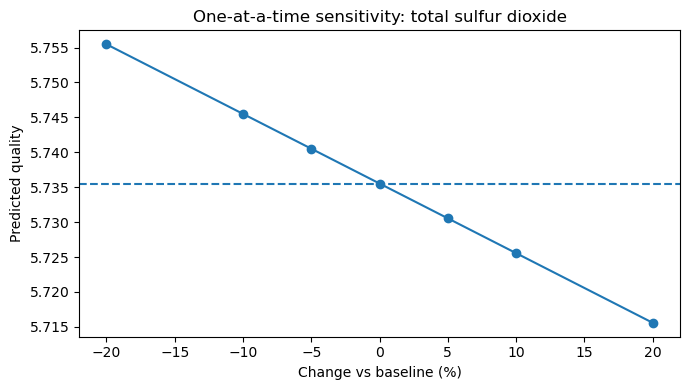

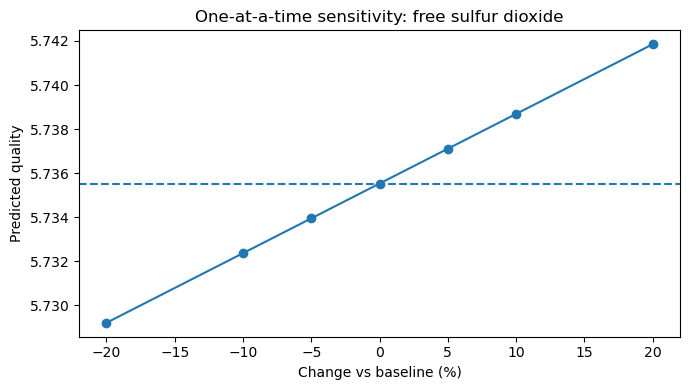

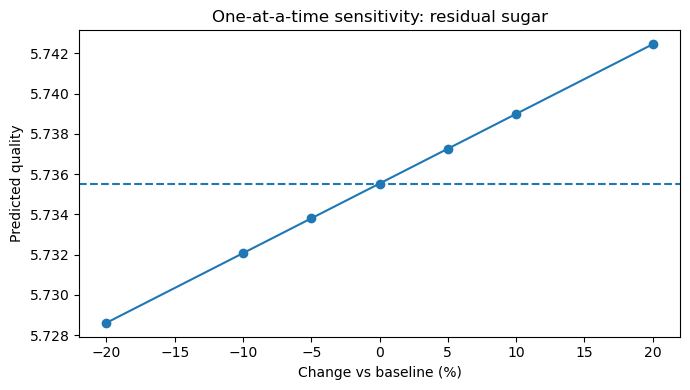

In [13]:
import matplotlib.pyplot as plt

for f in sim_features:
    df_f = sensitivity_results[sensitivity_results["feature"] == f].sort_values("delta_pct")

    plt.figure(figsize=(7, 4))
    plt.plot(df_f["delta_pct"], df_f["pred_quality"], marker="o")
    plt.axhline(baseline_pred_quality, linestyle="--")
    plt.title(f"One-at-a-time sensitivity: {f}")
    plt.xlabel("Change vs baseline (%)")
    plt.ylabel("Predicted quality")
    plt.tight_layout()
    plt.show()


## Leverage summary (±10% change)

To summarize interpretability, we compute the predicted quality change for a +10% and -10%
perturbation of each feature.


In [14]:
summary = []

for f in sim_features:
    df_f = sensitivity_results[sensitivity_results["feature"] == f]
    minus_10 = df_f[df_f["delta_pct"] == -10]["delta_quality"].values[0]
    plus_10 = df_f[df_f["delta_pct"] == 10]["delta_quality"].values[0]

    summary.append({
        "feature": f,
        "delta_quality_-10pct": minus_10,
        "delta_quality_+10pct": plus_10,
        "abs_max_impact_10pct": max(abs(minus_10), abs(plus_10))
    })

leverage_table = pd.DataFrame(summary).sort_values("abs_max_impact_10pct", ascending=False)
leverage_table


,feature,delta_quality_-10pct,delta_quality_+10pct,abs_max_impact_10pct
2,pH,0.129810,-0.129810,0.129810
0,volatile acidity,0.058750,-0.058750,0.058750
1,fixed acidity,-0.021653,0.021653,0.021653
3,total sulfur dioxide,0.009972,-0.009972,0.009972
5,residual sugar,-0.003457,0.003457,0.003457
4,free sulfur dioxide,-0.003159,0.003159,0.003159


## Save outputs for risk framework

We export sensitivity outputs to be reused in the risk labeling and classification notebook.


In [15]:
OUTPUT_PATH = Path("../data/processed")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

sensitivity_results.to_csv(OUTPUT_PATH / "scenario_sensitivity_results.csv", index=False)
leverage_table.to_csv(OUTPUT_PATH / "scenario_leverage_table.csv", index=False)


In [16]:
from pathlib import Path

OUTPUT_PATH = Path("../data/processed")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

sensitivity_results.to_csv(
    OUTPUT_PATH / "scenario_sensitivity_results.csv",
    index=False
)

leverage_table.to_csv(
    OUTPUT_PATH / "scenario_leverage_table.csv",
    index=False
)

print("Files saved:", list(OUTPUT_PATH.glob("*.csv")))


Files saved: [WindowsPath('../data/processed/scenario_leverage_table.csv'), WindowsPath('../data/processed/scenario_sensitivity_results.csv')]
